In [4]:
import os
from dotenv import load_dotenv
from nasdaqdatalink.api_config import NASDAQ_DATA_LINK_API_KEY

load_dotenv()

API_KEY = os.getenv('NASDAQ_API_KEY')

ModuleNotFoundError: No module named 'nasdaqdatalink'

In [3]:
import nasdaqdatalink

ModuleNotFoundError: No module named 'nasdaqdatalink'

In [5]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming the datasets are already loaded into dataframes
sf1_df = pd.read_csv('SHARADAR_SF1.csv')
tickers_df = pd.read_csv('SHARADAR_TICKERS.csv')
sp500_df = pd.read_csv('SHARADAR_SP500.csv')
indicators_df = pd.read_csv('SHARADAR_INDICATORS.csv')

# Calculate the date 10 years ago from today
ten_years_ago = (datetime.now() - timedelta(days=3650)).strftime('%Y-%m-%d')

# Filter for tech companies that had their IPO in the last 10 years
tech_startups = tickers_df[(tickers_df['sector'] == 'Technology') & 
                           (tickers_df['firstpricedate'] >= ten_years_ago)]

# Get the latest financial data for these companies from SF1
latest_financials = sf1_df[sf1_df['ticker'].isin(tech_startups['ticker']) & 
                           (sf1_df['dimension'] == 'MRY')]  # Most recent yearly data

# Merge the datasets to get all the information we need
tech_startup_ipos = pd.merge(tech_startups, latest_financials, on='ticker')

# Get the list of available columns
available_columns = tech_startup_ipos.columns.tolist()

desired_columns = ['ticker', 'name', 'sector', 'industry', 'firstpricedate', 
                   'revenue', 'netinc', 'assets', 'marketcap']

# Select only the columns that are actually in the dataframe
columns_to_use = [col for col in desired_columns if col in available_columns]

tech_startup_ipos = tech_startup_ipos[columns_to_use]

print("Number of tech startup IPOs in the last 10 years:", len(tech_startup_ipos))
print("\nSample of tech startup IPO data:")
print(tech_startup_ipos.head())

Number of tech startup IPOs in the last 10 years: 6406

Sample of tech startup IPO data:
  ticker         name      sector                 industry firstpricedate  \
0  ABILF  ABILITY INC  Technology  Communication Equipment     2015-12-24   
1  ABILF  ABILITY INC  Technology  Communication Equipment     2015-12-24   
2  ABILF  ABILITY INC  Technology  Communication Equipment     2015-12-24   
3  ABILF  ABILITY INC  Technology  Communication Equipment     2015-12-24   
4  ABILF  ABILITY INC  Technology  Communication Equipment     2015-12-24   

      revenue      netinc      assets   marketcap  
0   1726000.0  -6709000.0  13818000.0   5624299.0  
1   1885000.0  -7737000.0  17215000.0   2017497.0  
2    539000.0 -10189000.0  25374000.0   6278886.0  
3   2972000.0  -9111000.0  20464000.0  11332702.0  
4  16508000.0  -8053000.0  31835000.0  71344513.0  


In [6]:
import pandas as pd
from datetime import datetime, timedelta

# Load data with expanded column selection
sf1_df = pd.read_csv('SHARADAR_SF1.csv', usecols=['ticker', 'dimension', 'datekey', 'revenue', 'netinc', 'assets', 'liabilities', 'equity', 'fcf', 'ebitda', 'marketcap', 'pe', 'pb'])
tickers_df = pd.read_csv('SHARADAR_TICKERS.csv', usecols=['ticker', 'name', 'sector', 'industry', 'scalemarketcap', 'firstpricedate', 'lastpricedate'])

# Read events and daily files without specifying columns
events_df = pd.read_csv('SHARADAR_EVENTS.csv')
print("Columns in SHARADAR_EVENTS.csv:", events_df.columns)

daily_df = pd.read_csv('SHARADAR_DAILY.csv')
print("Columns in SHARADAR_DAILY.csv:", daily_df.columns)

actions_df = pd.read_csv('SHARADAR_ACTIONS.csv', usecols=['ticker', 'date', 'action', 'value'])

# Calculate the date 10 years ago from today
ten_years_ago = (datetime.now() - timedelta(days=3650)).strftime('%Y-%m-%d')

# Filter for tech companies that had their IPO in the last 10 years
tech_startups = tickers_df[(tickers_df['sector'] == 'Technology') & 
                           (tickers_df['firstpricedate'] >= ten_years_ago)]

# Get the latest financial data for these companies from SF1
latest_financials = sf1_df[sf1_df['ticker'].isin(tech_startups['ticker']) & 
                           (sf1_df['dimension'] == 'MRY')]  # Most recent yearly data

# Merge the datasets to get all the information we need
tech_startup_ipos = pd.merge(tech_startups, latest_financials, on='ticker')

# Select the desired columns
columns_to_use = ['ticker', 'name', 'sector', 'industry', 'scalemarketcap',
                  'firstpricedate', 'lastpricedate', 'revenue', 'netinc', 'assets', 'liabilities',
                  'equity', 'fcf', 'ebitda', 'marketcap', 'pe', 'pb']

tech_startup_ipos = tech_startup_ipos[columns_to_use]

# Convert dates to datetime
tech_startup_ipos['firstpricedate'] = pd.to_datetime(tech_startup_ipos['firstpricedate'])
tech_startup_ipos['lastpricedate'] = pd.to_datetime(tech_startup_ipos['lastpricedate'])
actions_df['date'] = pd.to_datetime(actions_df['date'])

# Sort tech_startup_ipos
tech_startup_ipos = tech_startup_ipos.sort_values(['ticker', 'firstpricedate'])

# Handle events data if available
if 'ticker' in events_df.columns and 'date' in events_df.columns:
    events_df['date'] = pd.to_datetime(events_df['date'])
    events_df = events_df.sort_values(['ticker', 'date'])
    enhanced_data = pd.merge(tech_startup_ipos, events_df,
                             left_on=['ticker', 'firstpricedate'],
                             right_on=['ticker', 'date'],
                             how='left')
else:
    print("Warning: 'ticker' or 'date' column not found in events_df. Skipping events merge.")
    enhanced_data = tech_startup_ipos

# Handle daily data if available
if 'ticker' in daily_df.columns and 'date' in daily_df.columns:
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    first_day_trading = daily_df[daily_df['ticker'].isin(tech_startup_ipos['ticker'])]
    first_day_trading = first_day_trading.sort_values(['ticker', 'date']).groupby('ticker').first().reset_index()
    enhanced_data = pd.merge(enhanced_data, first_day_trading, on='ticker', suffixes=('', '_first_day'), how='left')
else:
    print("Warning: 'ticker' or 'date' column not found in daily_df. Skipping first day trading data merge.")

# Get relevant corporate actions within the first year after IPO
actions_df['year_after_date'] = actions_df['date'] + pd.DateOffset(years=1)
actions_df = actions_df.sort_values(['ticker', 'date'])

# Merge the first action for each company
first_actions = actions_df.groupby('ticker').first().reset_index()
enhanced_data = pd.merge(enhanced_data, first_actions, on='ticker', how='left', suffixes=('', '_first_action'))

def get_first_year_actions(row, actions_df):
    return actions_df[(actions_df['ticker'] == row['ticker']) & 
                      (actions_df['date'] > row['firstpricedate']) & 
                      (actions_df['date'] <= row['year_after_date'])]

enhanced_data['first_year_actions'] = enhanced_data.apply(
    lambda row: get_first_year_actions(row, actions_df), axis=1
)

print("Number of tech startup IPOs in the last 10 years:", len(enhanced_data))
print("\nSample of enhanced tech startup IPO data:")
print(enhanced_data.head())
print(f"\nNumber of companies with enhanced data: {len(enhanced_data)}")


Columns in SHARADAR_EVENTS.csv: Index(['ticker', 'date', 'eventcodes'], dtype='object')
Columns in SHARADAR_DAILY.csv: Index(['ticker', 'date', 'lastupdated', 'ev', 'evebit', 'evebitda',
       'marketcap', 'pb', 'pe', 'ps'],
      dtype='object')
Number of tech startup IPOs in the last 10 years: 6406

Sample of enhanced tech startup IPO data:
  ticker         name      sector                 industry scalemarketcap  \
0  ABILF  ABILITY INC  Technology  Communication Equipment      2 - Micro   
1  ABILF  ABILITY INC  Technology  Communication Equipment      2 - Micro   
2  ABILF  ABILITY INC  Technology  Communication Equipment      2 - Micro   
3  ABILF  ABILITY INC  Technology  Communication Equipment      2 - Micro   
4  ABILF  ABILITY INC  Technology  Communication Equipment      2 - Micro   

  firstpricedate lastpricedate     revenue      netinc      assets  ...  \
0     2015-12-24    2021-12-01   1726000.0  -6709000.0  13818000.0  ...   
1     2015-12-24    2021-12-01   1885000.

In [7]:
def improved_clean_data(df, batch_size=1000):
    print("Improved Data Cleaning Process")
    print("=" * 30)

    df = df.copy()
    total_rows = len(df)
    cleaned_data = []

    for i in range(0, total_rows, batch_size):
        batch = df.iloc[i:i+batch_size].copy()
        print(f"\nProcessing batch {i//batch_size + 1}")
        
        print("Removing rows with missing tickers...")
        batch = batch.dropna(subset=['ticker'])

        print("Handling missing financial data...")
        financial_columns = ['revenue', 'netinc', 'assets', 'liabilities', 'equity', 'fcf', 'ebitda', 'marketcap', 'pe', 'pb']
        for col in financial_columns:
            batch[f'{col}_missing'] = batch[col].isnull().astype(int)
            if batch[col].isnull().sum() < batch_size / 10:
                batch[col] = batch[col].fillna(batch[col].median())
            else:
                batch[col] = batch[col].fillna(0)

        print("Flagging missing event data...")
        batch['event_missing'] = batch['eventcodes'].isnull().astype(int)

        print("Handling missing action data...")
        action_columns = ['date_first_action', 'action', 'value']
        for col in action_columns:
            batch[f'{col}_missing'] = batch[col].isnull().astype(int)
            if col == 'value':
                batch[col] = batch[col].fillna(0)
            else:
                batch[col] = batch[col].fillna('Unknown')

        print("Handling other missing data...")
        other_columns = ['scalemarketcap', 'ps']
        for col in other_columns:
            batch[f'{col}_missing'] = batch[col].isnull().astype(int)
            if col == 'scalemarketcap':
                batch[col] = batch[col].fillna('Unknown')
            else:
                batch[col] = batch[col].fillna(batch[col].median())

        print("Converting date columns...")
        date_columns = ['firstpricedate', 'lastpricedate', 'date', 'date_first_day', 'date_first_action', 'year_after_date']
        for col in date_columns:
            if col in batch.columns:
                batch[col] = pd.to_datetime(batch[col], errors='coerce')

        cleaned_data.append(batch)
        print(f"Processed {min(i+batch_size, total_rows)} out of {total_rows} rows")

    print("\nConcatenating cleaned batches...")
    cleaned_df = pd.concat(cleaned_data, ignore_index=True)
    print("Data cleaning completed.")
    print(f"Final number of rows: {len(cleaned_df)}")

    return cleaned_df

def data_quality_checks(df):
    print("Performing data quality checks...")
    print(f"Total number of rows: {len(df)}")
    print(f"Number of columns: {len(df.columns)}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData types:")
    print(df.dtypes)
    print("\nSummary statistics:")
    print(df.describe())

# Use the function with a smaller batch size
print("Starting the cleaning process...")
cleaned_data = improved_clean_data(enhanced_data, batch_size=1000)

# Run data quality checks on cleaned data
print("\nRunning data quality checks...")
data_quality_checks(cleaned_data)

# Save the cleaned data
print("\nSaving cleaned data to CSV...")
cleaned_data.to_csv('improved_cleaned_enhanced_data.csv', index=False)
print("Cleaned data saved to 'improved_cleaned_enhanced_data.csv'")
print("All operations completed.")

Starting the cleaning process...
Improved Data Cleaning Process

Processing batch 1
Removing rows with missing tickers...
Handling missing financial data...
Flagging missing event data...
Handling missing action data...
Handling other missing data...
Converting date columns...
Processed 1000 out of 6406 rows

Processing batch 2
Removing rows with missing tickers...
Handling missing financial data...
Flagging missing event data...
Handling missing action data...
Handling other missing data...
Converting date columns...
Processed 2000 out of 6406 rows

Processing batch 3
Removing rows with missing tickers...
Handling missing financial data...
Flagging missing event data...
Handling missing action data...
Handling other missing data...
Converting date columns...
Processed 3000 out of 6406 rows

Processing batch 4
Removing rows with missing tickers...
Handling missing financial data...
Flagging missing event data...
Handling missing action data...
Handling other missing data...
Converting 

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

fred_api_key = os.getenv('FRED_API_KEY')

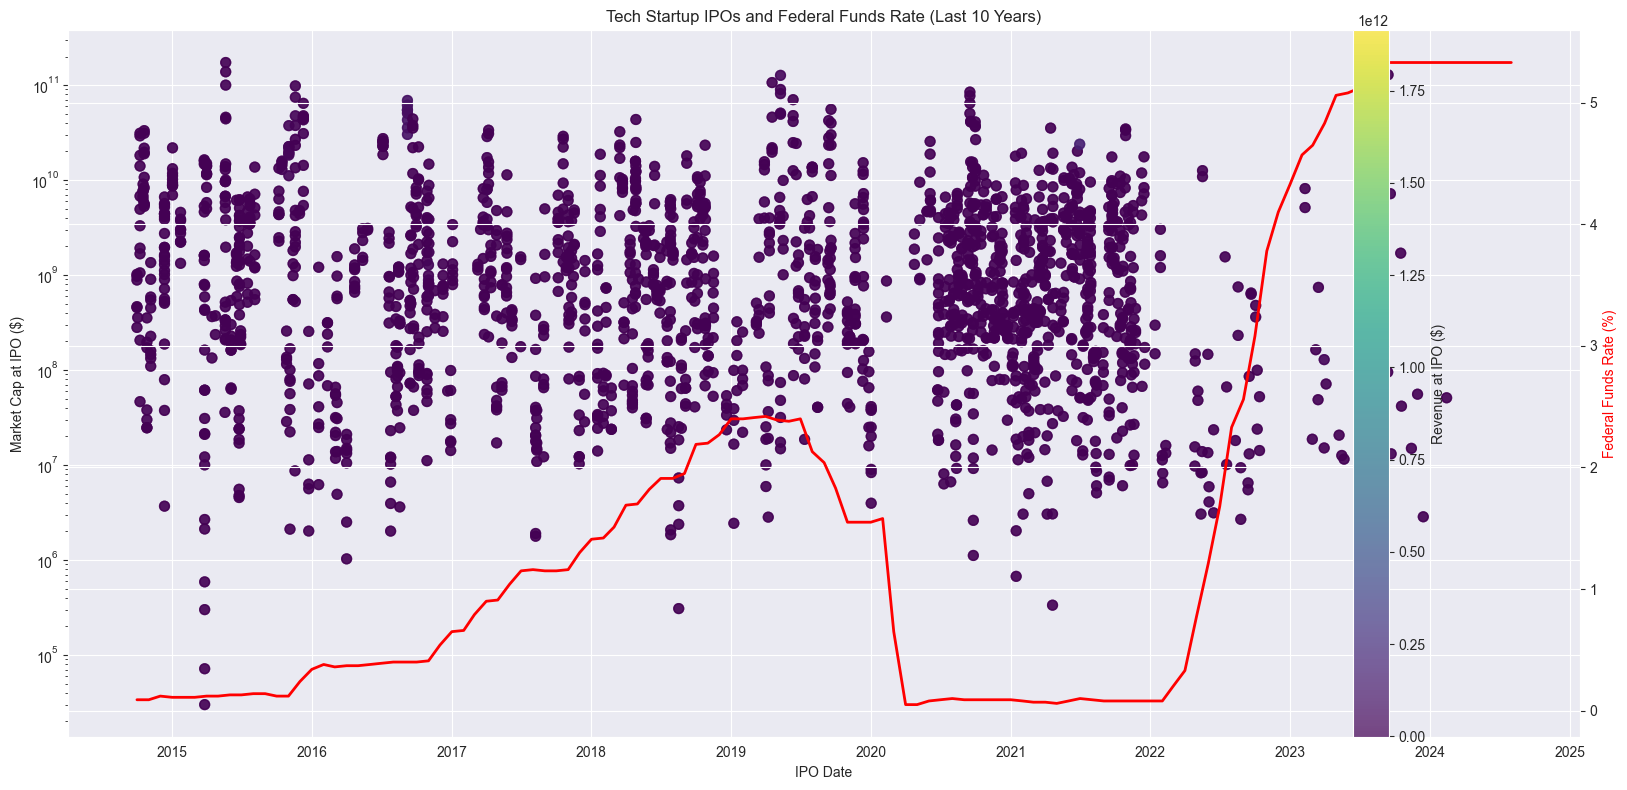

In [9]:
import os
from dotenv import load_dotenv
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables and data
load_dotenv()
df = pd.read_csv('improved_cleaned_enhanced_data.csv')

# Fetch Federal Funds Rate data
fred_client = Fred(api_key=os.getenv('FRED_API_KEY'))
ffr_data = fred_client.get_series('FEDFUNDS')

# Prepare the IPO data and filter for the last 10 years
df['firstpricedate'] = pd.to_datetime(df['firstpricedate'])
ten_years_ago = pd.Timestamp.now() - pd.DateOffset(years=10)
df_filtered = df[df['firstpricedate'] > ten_years_ago].sort_values('firstpricedate')

# Filter FFR data for the last 10 years
ffr_data_filtered = ffr_data[ffr_data.index > ten_years_ago]

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot IPOs
scatter = ax1.scatter(df_filtered['firstpricedate'], df_filtered['marketcap'], 
                      alpha=0.7, c=df_filtered['revenue'], cmap='viridis', s=50)
ax1.set_ylabel('Market Cap at IPO ($)')
ax1.set_xlabel('IPO Date')
ax1.set_yscale('log')

# Plot Federal Funds Rate
ax2 = ax1.twinx()
ax2.plot(ffr_data_filtered.index, ffr_data_filtered.values, color='red', linewidth=2)
ax2.set_ylabel('Federal Funds Rate (%)', color='red')

plt.title('Tech Startup IPOs and Federal Funds Rate (Last 10 Years)')
plt.colorbar(scatter, label='Revenue at IPO ($)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [10]:
last_10_years_ffr = ffr_data_filtered.resample('YE').mean()

print("Federal Funds Rate (Annual Average) for the Last 10 Years:")
for year, rate in last_10_years_ffr.items():
    print(f"{year.year}: {rate:.2f}%")

Federal Funds Rate (Annual Average) for the Last 10 Years:
2014: 0.10%
2015: 0.13%
2016: 0.40%
2017: 1.00%
2018: 1.83%
2019: 2.16%
2020: 0.38%
2021: 0.08%
2022: 1.68%
2023: 5.02%
2024: 5.33%


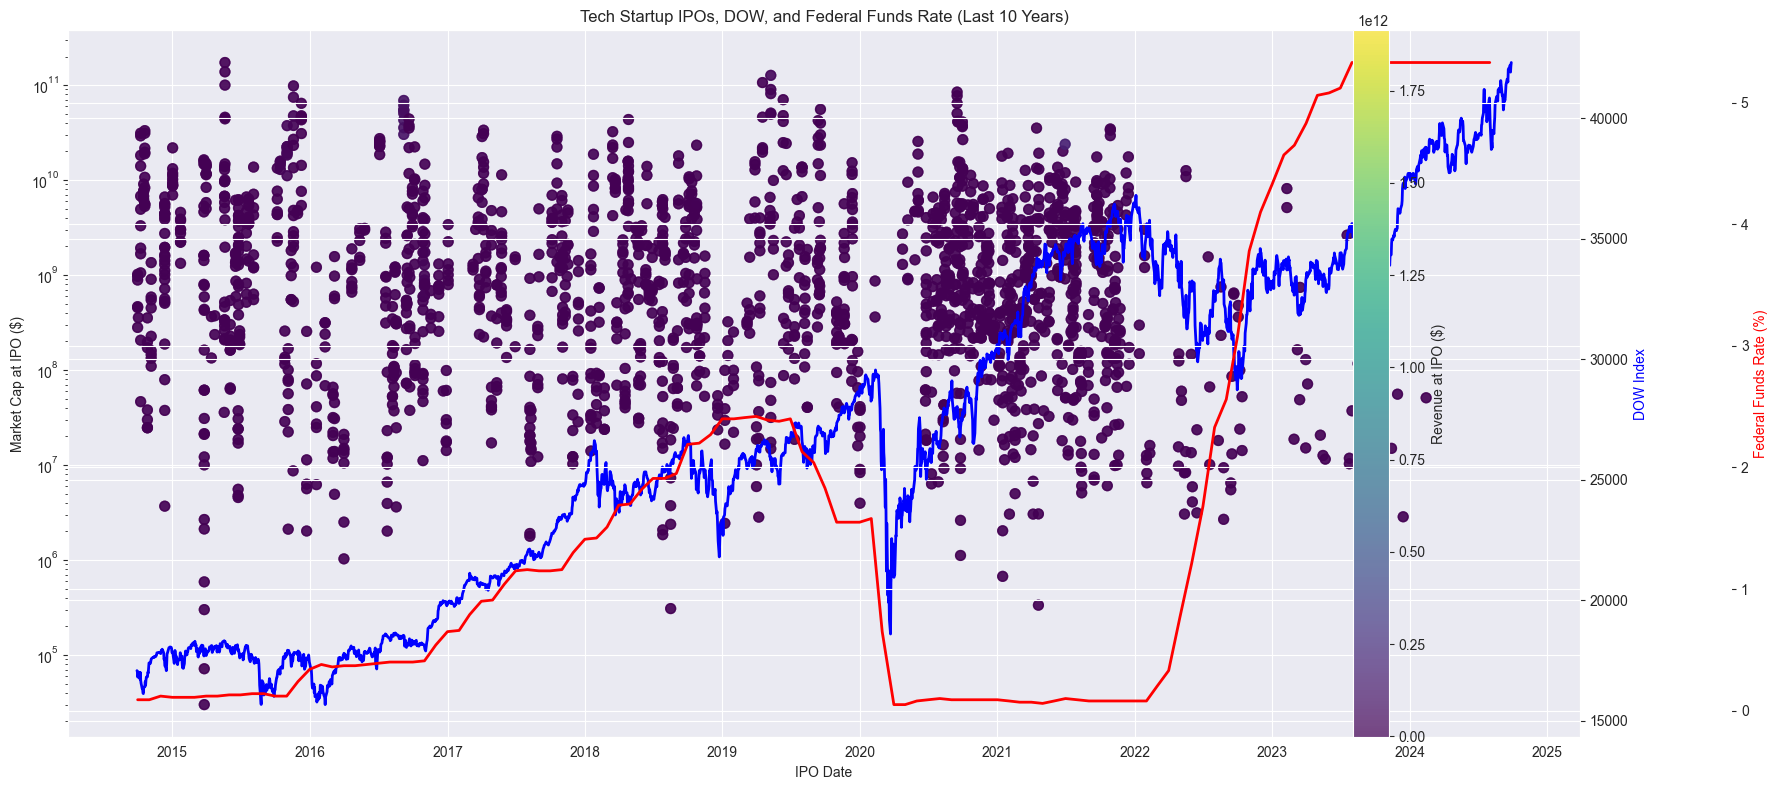

In [11]:
import yfinance as yf

# Fetch DOW data
dow = yf.Ticker("^DJI")
dow_data = dow.history(start=ten_years_ago)

# Create the plot
fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot IPOs
scatter = ax1.scatter(df_filtered['firstpricedate'], df_filtered['marketcap'], 
                      alpha=0.7, c=df_filtered['revenue'], cmap='viridis', s=50)
ax1.set_ylabel('Market Cap at IPO ($)')
ax1.set_xlabel('IPO Date')
ax1.set_yscale('log')

# Plot DOW
ax2 = ax1.twinx()
ax2.plot(dow_data.index, dow_data['Close'], color='blue', linewidth=2)
ax2.set_ylabel('DOW Index', color='blue')

# Plot Federal Funds Rate
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))
ax3.plot(ffr_data_filtered.index, ffr_data_filtered.values, color='red', linewidth=2)
ax3.set_ylabel('Federal Funds Rate (%)', color='red')

plt.title('Tech Startup IPOs, DOW, and Federal Funds Rate (Last 10 Years)')
plt.colorbar(scatter, label='Revenue at IPO ($)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import numpy as np 

df = pd.read_csv('improved_cleaned_enhanced_data.csv')

# Create new ratio columns
df['FCF_to_EBITDA'] = df['fcf'] / df['ebitda']
df['FCF_to_Revenue'] = df['fcf'] / df['revenue']
df['Revenue_to_EBITDA'] = df['revenue'] / df['ebitda']
df['Assets_to_Liabilities'] = df['assets'] / df['liabilities']

# Handle potential division by zero or infinity
for column in ['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']:
    df[column] = df[column].replace([np.inf, -np.inf], np.nan)

# Save the updated dataframe
df.to_csv('improved_cleaned_enhanced_data_with_ratios.csv', index=False)

print("New ratio columns added and saved to 'improved_cleaned_enhanced_data_with_ratios.csv'")
print(df[['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']].describe())

New ratio columns added and saved to 'improved_cleaned_enhanced_data_with_ratios.csv'
       FCF_to_EBITDA  FCF_to_Revenue  Revenue_to_EBITDA  Assets_to_Liabilities
count    6398.000000     6200.000000        6398.000000            6388.000000
mean       -0.245699      -11.167343           0.676286               3.231870
std        39.028887      227.760163         156.740029              16.819760
min     -2154.607143    -9789.824405       -6961.178571               0.000000
25%         0.082203       -0.388904          -3.398494               1.193396
50%         0.571584       -0.042716          -0.156732               1.746863
75%         0.990476        0.070407           5.651466               2.744058
max       170.618271       66.755787        2848.876923             915.210232


In [13]:
import pandas as pd
import numpy as np

# Load the existing dataset
df = pd.read_csv('improved_cleaned_enhanced_data.csv')

# Load the SHARADAR_SF1 dataset
sf1_df = pd.read_csv('SHARADAR_SF1.csv')

# List of new columns to add
all_new_columns = ['capex', 'ncfbus', 'ncfinv', 'fcfps', 'ncff', 'ncfi', 'ncfo', 'ncfx', 
                   'cashneq', 'investments', 'investmentsc', 'investmentsnc', 
                   'assetsc', 'roa', 'roe', 'roic', 'ros']

# Filter out columns that already exist in df
new_columns = [col for col in all_new_columns if col not in df.columns]

print(f"Columns to be added: {new_columns}")

# Check which columns are available in both dataframes
common_columns = list(set(df.columns) & set(sf1_df.columns))

print(f"Common columns for merging: {common_columns}")

if 'ticker' in common_columns:
    # If 'ticker' is available, we'll use it for merging
    merge_columns = ['ticker']
    
    # Merge the dataframes
    merged_df = pd.merge(df, sf1_df[merge_columns + new_columns], 
                         on=merge_columns, how='left')
    
    # Handle any potential NaN values
    for column in new_columns:
        merged_df[column] = merged_df[column].fillna(0)
    
    # Save the updated dataframe
    merged_df.to_csv('improved_cleaned_enhanced_data_with_new_columns.csv', index=False)
    
    print("New columns added and saved to 'improved_cleaned_enhanced_data_with_new_columns.csv'")
    print(merged_df[new_columns].describe())
else:
    print("Error: No common columns suitable for merging found between the datasets.")
    print("Available columns in SHARADAR_SF1.csv:")
    print(sf1_df.columns.tolist())

Columns to be added: ['capex', 'ncfbus', 'ncfinv', 'fcfps', 'ncff', 'ncfi', 'ncfo', 'ncfx', 'cashneq', 'investments', 'investmentsc', 'investmentsnc', 'assetsc', 'roa', 'roe', 'roic', 'ros']
Common columns for merging: ['lastupdated', 'evebitda', 'revenue', 'equity', 'evebit', 'liabilities', 'ticker', 'pe', 'marketcap', 'assets', 'ev', 'pb', 'ps', 'ebitda', 'fcf', 'netinc']
New columns added and saved to 'improved_cleaned_enhanced_data_with_new_columns.csv'
              capex        ncfbus        ncfinv         fcfps          ncff  \
count  6.649660e+05  6.649660e+05  6.649660e+05  6.649660e+05  6.649660e+05   
mean  -8.326268e+07 -4.828388e+07 -5.193121e+07 -1.566954e+04 -6.363549e+06   
std    7.787919e+08  7.380039e+08  4.550904e+09  1.810969e+06  7.036484e+09   
min   -5.894000e+10 -3.761400e+10 -4.282210e+11 -2.714073e+08 -6.759700e+11   
25%   -1.427200e+07 -5.000000e+05  0.000000e+00 -4.570000e-01 -9.710000e+05   
50%   -2.135000e+06  0.000000e+00  0.000000e+00  0.000000e+00  4

In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('improved_cleaned_enhanced_data_with_new_columns.csv')

# Create new ratio columns
df['FCF_to_EBITDA'] = df['fcf'] / df['ebitda']
df['FCF_to_Revenue'] = df['fcf'] / df['revenue']
df['Revenue_to_EBITDA'] = df['revenue'] / df['ebitda']
df['Assets_to_Liabilities'] = df['assets'] / df['liabilities']

# Handle potential division by zero or infinity
for column in ['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']:
    df[column] = df[column].replace([np.inf, -np.inf], np.nan)

# Save the updated dataframe
df.to_csv('improved_cleaned_enhanced_data_with_new_columns1.csv', index=False)

print("New ratio columns added and saved to 'improved_cleaned_enhanced_data_with_new_columns1.csv'")
print(df[['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']].describe())

C:\Users\Katarina\AppData\Local\Temp\ipykernel_13504\2353682969.py:4: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('improved_cleaned_enhanced_data_with_new_columns.csv')


New ratio columns added and saved to 'improved_cleaned_enhanced_data_with_new_columns1.csv'
       FCF_to_EBITDA  FCF_to_Revenue  Revenue_to_EBITDA  Assets_to_Liabilities
count  664966.000000   642848.000000      664966.000000          663976.000000
mean       -0.210004      -10.271779           2.250564               3.021647
std        38.069759      209.348969         156.701612              11.994848
min     -2154.607143    -9789.824405       -6961.178571               0.000000
25%         0.068906       -0.376988          -3.524082               1.192201
50%         0.569075       -0.035173          -0.134498               1.717487
75%         0.974373        0.073514           6.033683               2.648684
max       170.618271       66.755787        2848.876923             915.210232


In [15]:
import pandas as pd
import numpy as np
from scipy import stats

# Load the data
df = pd.read_csv('improved_cleaned_enhanced_data_with_new_columns1.csv')

# Function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# List of ratio columns to clean
ratio_columns = ['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']

# Remove outliers from ratio columns
for column in ratio_columns:
    df = remove_outliers(df, column)

# Handle missing values
df = df.dropna(subset=ratio_columns)

# Normalize distributions using log transformation
# Adding a small constant to avoid log(0)
for column in ratio_columns:
    df[f'{column}_log'] = np.log(df[column] + 1e-5)

# Create a categorical variable for company size based on assets
df['company_size'] = pd.qcut(df['assets'], q=3, labels=['Small', 'Medium', 'Large'])

# Check for multicollinearity
correlation_matrix = df[ratio_columns].corr()

# Print summary statistics after cleaning
print(df[ratio_columns].describe())

# Print correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Save the cleaned dataset
df.to_csv('cleaned_financial_data.csv', index=False)

print("\nCleaned data saved to 'cleaned_financial_data.csv'")

C:\Users\Katarina\AppData\Local\Temp\ipykernel_13504\196519567.py:6: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('improved_cleaned_enhanced_data_with_new_columns1.csv')
C:\Users\Katarina\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Katarina\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Katarina\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


       FCF_to_EBITDA  FCF_to_Revenue  Revenue_to_EBITDA  Assets_to_Liabilities
count  376622.000000   376622.000000      376622.000000          376622.000000
mean        0.484461       -0.055831           1.085157               1.736592
std         0.618442        0.257016           7.320300               0.811599
min        -1.269891       -1.001897         -18.741305               0.004409
25%         0.112295       -0.147954          -3.726926               1.184978
50%         0.493670        0.005094          -0.751025               1.599141
75%         0.851796        0.091407           6.060122               2.160673
max         2.327093        0.662539          21.894844               4.130377

Correlation Matrix:
                       FCF_to_EBITDA  FCF_to_Revenue  Revenue_to_EBITDA  \
FCF_to_EBITDA               1.000000       -0.054084           0.166696   
FCF_to_Revenue             -0.054084        1.000000           0.289698   
Revenue_to_EBITDA           0.166696       

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('cleaned_financial_data.csv')

# Check data types of all columns
print(df.dtypes)

# Investigate columns 17 and 18 (adjust index if necessary)
print(df.iloc[:, 16:19].head())

# Function for signed log transformation
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Apply signed log transformation to ratio columns
ratio_columns = ['FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities']
for column in ratio_columns:
    df[f'{column}_signed_log'] = signed_log(df[column])

# Create dummy variables for company_size
df = pd.get_dummies(df, columns=['company_size'], prefix='size')

# Scale numerical features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=[np.number]).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Exploratory Data Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(df[ratio_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Ratio Columns')
plt.savefig('correlation_heatmap.png')
plt.close()

# Distribution plots for transformed ratio columns
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
for i, column in enumerate(ratio_columns):
    sns.histplot(df[f'{column}_signed_log'], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {column} (Signed Log)')
plt.tight_layout()
plt.savefig('distribution_plots.png')
plt.close()

# Save the further cleaned and processed data
df.to_csv('final_cleaned_financial_data.csv', index=False)

print("Further cleaned and processed data saved to 'final_cleaned_financial_data.csv'")
print("Correlation heatmap saved as 'correlation_heatmap.png'")
print("Distribution plots saved as 'distribution_plots.png'")

C:\Users\Katarina\AppData\Local\Temp\ipykernel_13504\4205713046.py:8: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_financial_data.csv')


ticker                        object
name                          object
sector                        object
industry                      object
scalemarketcap                object
                              ...   
FCF_to_EBITDA_log            float64
FCF_to_Revenue_log           float64
Revenue_to_EBITDA_log        float64
Assets_to_Liabilities_log    float64
company_size                  object
Length: 75, dtype: object
      pb date eventcodes
0 -0.608  NaN        NaN
1 -0.608  NaN        NaN
2 -0.608  NaN        NaN
3 -0.608  NaN        NaN
4 -0.608  NaN        NaN
Further cleaned and processed data saved to 'final_cleaned_financial_data.csv'
Correlation heatmap saved as 'correlation_heatmap.png'
Distribution plots saved as 'distribution_plots.png'


In [17]:
# Load the data
df = pd.read_csv('final_cleaned_financial_data.csv', low_memory=False)

# Convert 'pb' to numeric, coercing errors to NaN
df['pb'] = pd.to_numeric(df['pb'], errors='coerce')

# Check the 'date' column
print("Unique values in 'date' column:")
print(df['date'].unique())

# If 'date' is entirely NaN, we might want to drop it
if df['date'].isna().all():
    df = df.drop('date', axis=1)
    print("'date' column dropped as it contained only NaN values")

# Check 'eventcodes' column
print("\nUnique values in 'eventcodes' column:")
print(df['eventcodes'].unique())

# If 'eventcodes' is not relevant or contains mostly NaN, consider dropping it
if df['eventcodes'].isna().sum() / len(df) > 0.5:  # if more than 50% are NaN
    df = df.drop('eventcodes', axis=1)
    print("'eventcodes' column dropped due to high proportion of NaN values")

# Check for any remaining columns with high proportion of missing values
missing_prop = df.isnull().mean()
columns_to_drop = missing_prop[missing_prop > 0.5].index
df = df.drop(columns_to_drop, axis=1)
print(f"\nColumns dropped due to high proportion of missing values: {list(columns_to_drop)}")

# Fill remaining NaN values with median for numeric columns and mode for categorical columns
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

# Print summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
print(df.describe())

# Generate correlation heatmap for numeric columns
plt.figure(figsize=(20, 16))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Columns')
plt.savefig('final_correlation_heatmap.png')
plt.close()

# Save the final cleaned dataset
df.to_csv('final_cleaned_financial_data_v2.csv', index=False)
print("\nFinal cleaned data saved to 'final_cleaned_financial_data_v2.csv'")
print("Final correlation heatmap saved as 'final_correlation_heatmap.png'")

Unique values in 'date' column:
[nan '2017-11-03' '2018-09-04' '2018-04-18' '2016-08-12' '2018-11-02'
 '2017-11-30' '2021-10-08' '2019-06-13' '2017-06-30' '2020-06-26'
 '2017-01-03' '2015-11-18' '2015-11-30' '2016-09-07' '2023-07-25'
 '2017-08-08' '2017-12-14' '2021-10-14' '2021-10-05' '2021-06-15'
 '2021-11-04' '2019-06-26' '2020-09-11' '2021-11-08' '2020-08-27'
 '2017-09-01' '2022-10-07' '2016-07-25' '2021-07-20' '2023-10-17'
 '2021-10-06' '2018-01-24' '2021-08-30' '2017-08-29' '2016-12-21'
 '2021-09-15' '2015-05-21' '2023-03-31' '2021-11-19' '2018-10-26'
 '2016-12-29' '2021-01-29']

Unique values in 'eventcodes' column:
[nan '11|91' '81|91' '81' '91.0' '81.0' '11|21|23|33|51|52|53|55|91'
 '11|32|52|81|91' '11|31|32|81|91' '33|57|71|81|91' '34.0'
 '11|23|33|51|52|53|71|91' '11|52|53|81|91' '11|21|51|52|53|81|91' '71|91'
 '11|21|23|51|52|53|81|91' '11|23|33|51|52|53|55|81|91'
 '11|21|23|52|56|81|91' '22|91']
'eventcodes' column dropped due to high proportion of NaN values

Columns dro

Dataset shape: (376622, 78)

Columns: ['ticker', 'name', 'sector', 'industry', 'scalemarketcap', 'firstpricedate', 'lastpricedate', 'revenue', 'netinc', 'assets', 'liabilities', 'equity', 'fcf', 'ebitda', 'marketcap', 'pe', 'pb', 'date_first_day', 'lastupdated', 'ev', 'evebit', 'evebitda', 'marketcap_first_day', 'pb_first_day', 'pe_first_day', 'ps', 'date_first_action', 'action', 'value', 'year_after_date', 'first_year_actions', 'revenue_missing', 'netinc_missing', 'assets_missing', 'liabilities_missing', 'equity_missing', 'fcf_missing', 'ebitda_missing', 'marketcap_missing', 'pe_missing', 'pb_missing', 'event_missing', 'date_first_action_missing', 'action_missing', 'value_missing', 'scalemarketcap_missing', 'ps_missing', 'capex', 'ncfbus', 'ncfinv', 'fcfps', 'ncff', 'ncfi', 'ncfo', 'ncfx', 'cashneq', 'investments', 'investmentsc', 'investmentsnc', 'assetsc', 'roa', 'roe', 'roic', 'ros', 'FCF_to_EBITDA', 'FCF_to_Revenue', 'Revenue_to_EBITDA', 'Assets_to_Liabilities', 'FCF_to_EBITDA_log

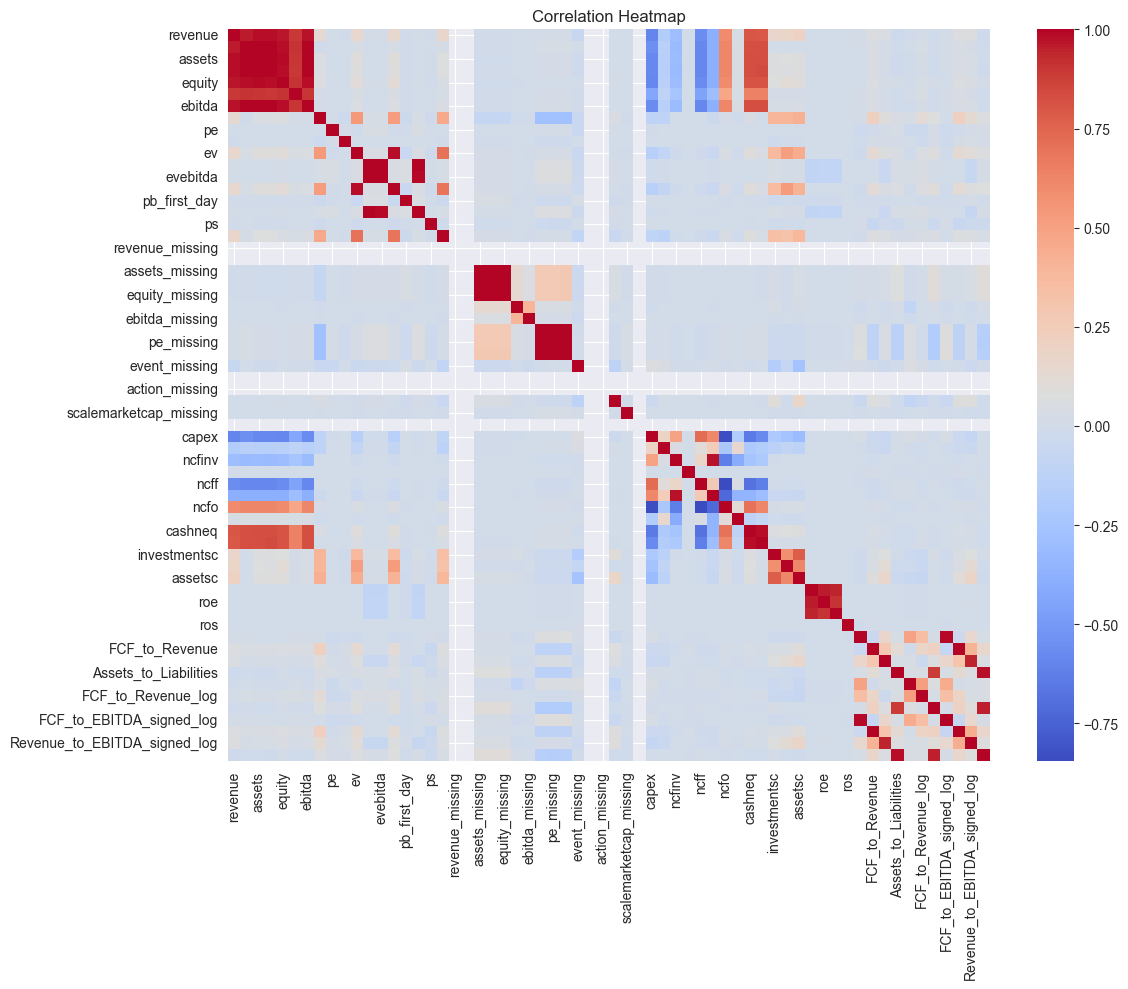

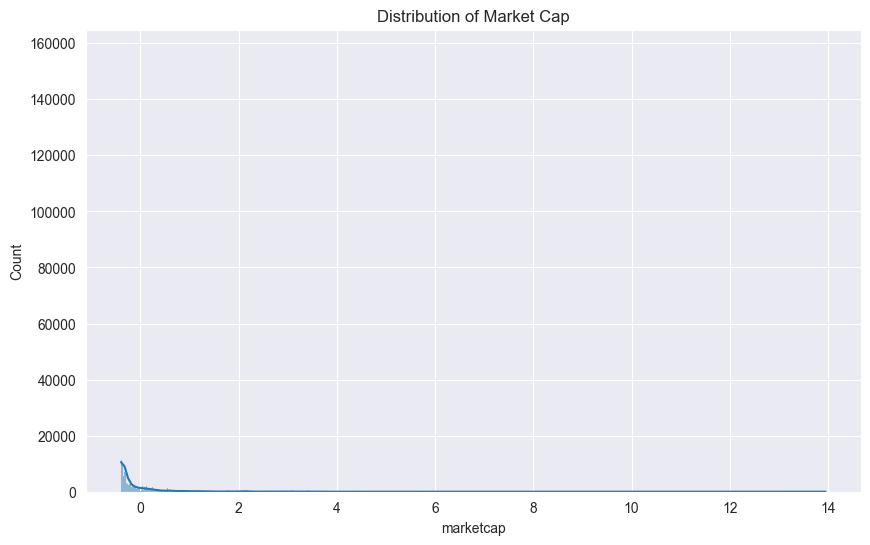

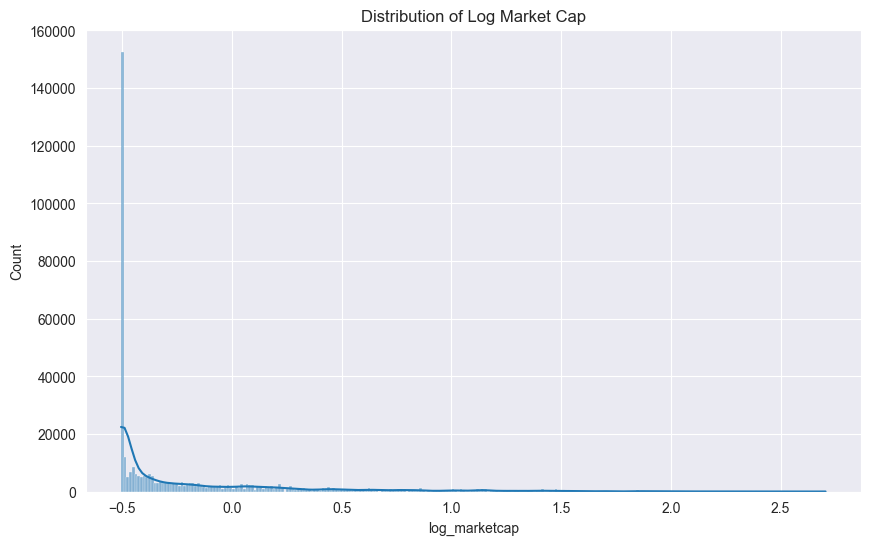


Top 10 features by Mutual Information Score:
Revenue_to_EBITDA_signed_log        5.384374
FCF_to_EBITDA_signed_log            5.384316
FCF_to_EBITDA                       5.382175
Revenue_to_EBITDA                   5.381969
FCF_to_Revenue                      5.381830
Assets_to_Liabilities               5.380901
FCF_to_Revenue_signed_log           5.380871
Assets_to_Liabilities_signed_log    5.380808
Assets_to_Liabilities_log           5.380722
revenue                             5.380588
Name: MI Scores, dtype: float64


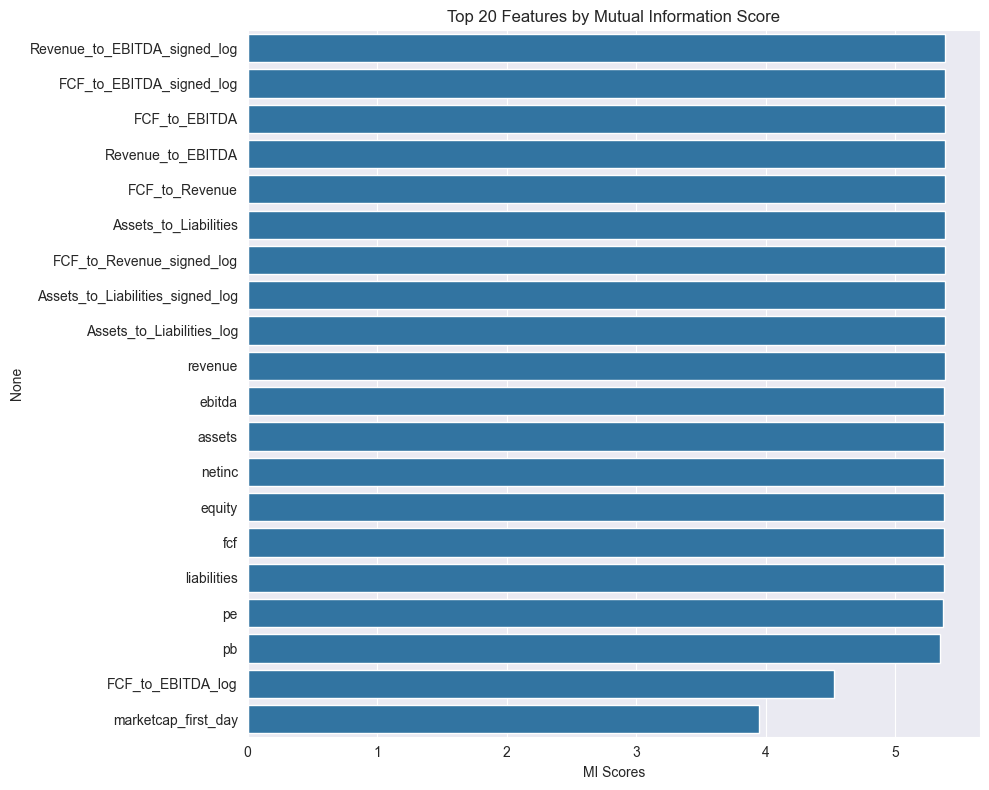

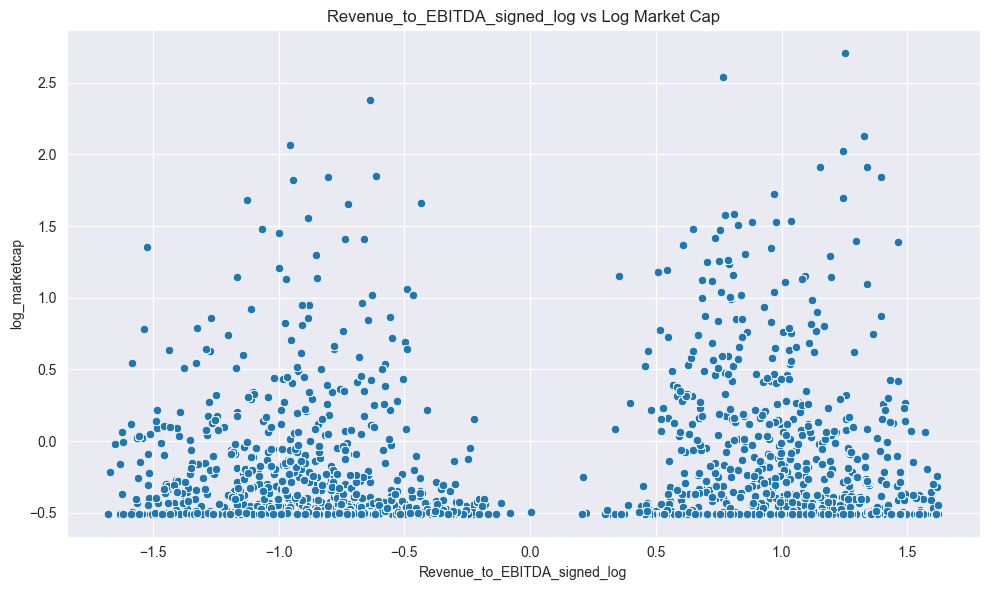

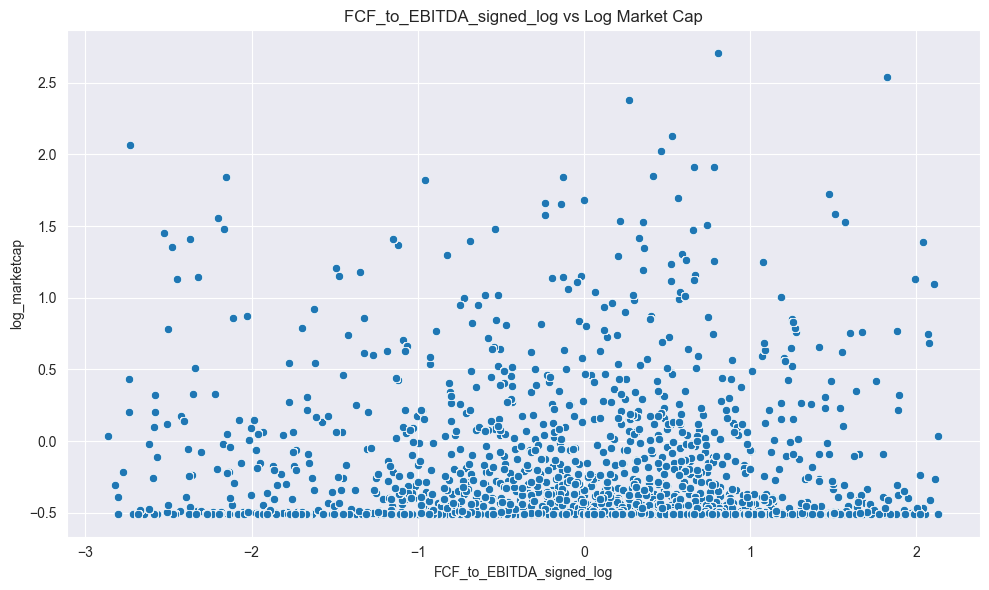

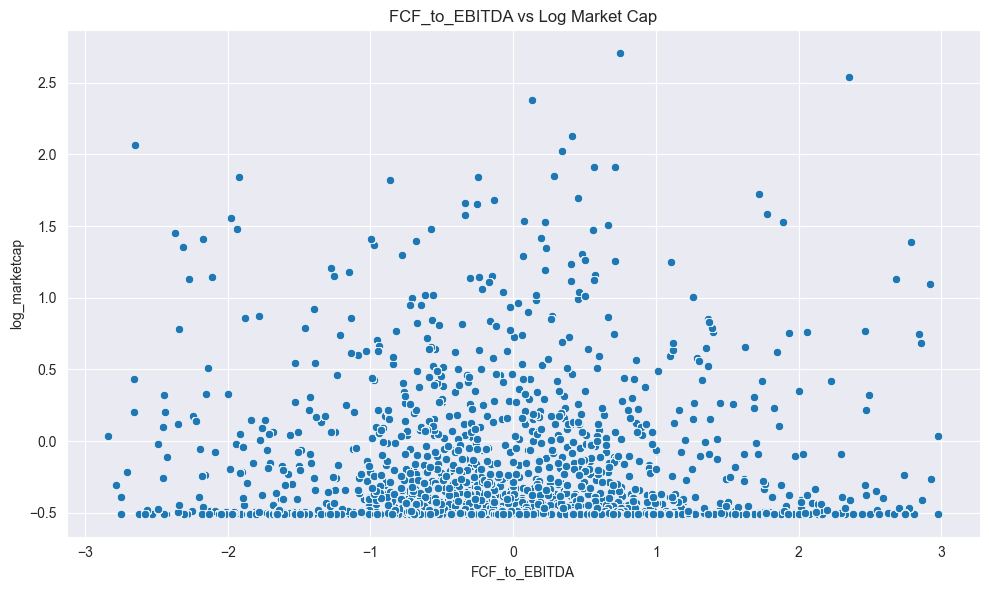

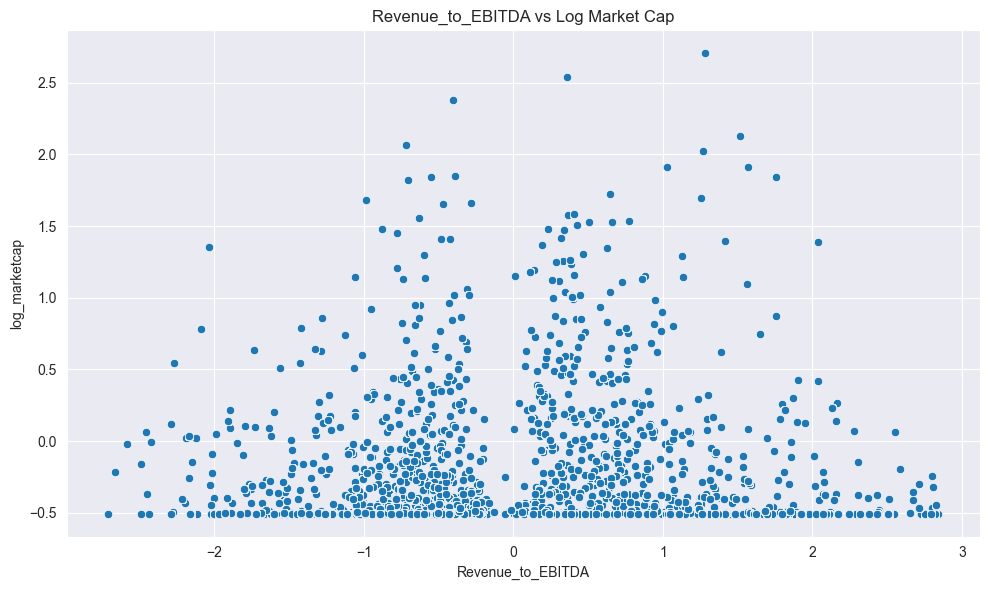

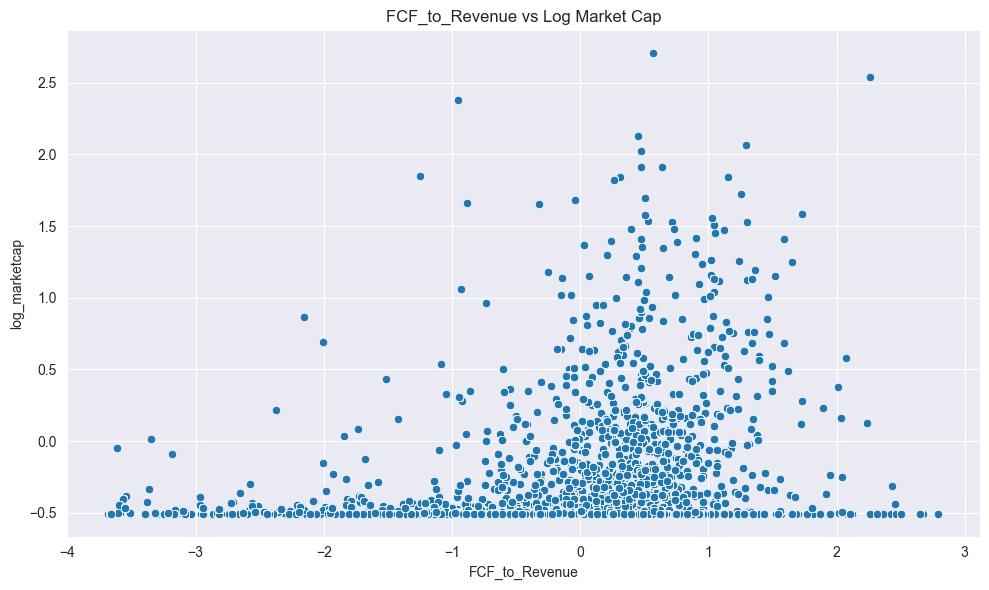


EDA completed. Check visualizations.

Unique values in ticker:
ticker
INLX    3860
QRVO    3740
HPE     3700
LITE    3564
ALRM    3560
Name: count, dtype: int64

Unique values in name:
name
INTELLINETICS INC                3860
QORVO INC                        3740
HEWLETT PACKARD ENTERPRISE CO    3700
LUMENTUM HOLDINGS INC            3564
ALARMCOM HOLDINGS INC            3560
Name: count, dtype: int64

Unique values in sector:
sector
Technology    376622
Name: count, dtype: int64

Unique values in industry:
industry
Software - Application             162022
Software - Infrastructure          105076
Communication Equipment             25344
Information Technology Services     20528
Semiconductors                      14826
Name: count, dtype: int64

Unique values in scalemarketcap:
scalemarketcap
4 - Mid      138630
5 - Large    101726
3 - Small     84756
2 - Micro     40700
1 - Nano      10678
Name: count, dtype: int64

Unique values in firstpricedate:
firstpricedate
2014-12-12    67

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('final_cleaned_financial_data_v2.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Separate numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

print("\nNumeric columns:", numeric_columns.tolist())
print("\nCategorical columns:", categorical_columns.tolist())

# Basic statistics of numeric columns
print("\nBasic statistics of numerical columns:")
print(df[numeric_columns].describe())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Correlation with target variable (using only numeric columns)
correlations = df[numeric_columns].corr()['marketcap'].sort_values(ascending=False)
print("\nTop 10 correlations with marketcap:")
print(correlations.head(11))  # 11 because marketcap itself will be included

# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['marketcap'], kde=True)
plt.title('Distribution of Market Cap')
plt.show()

# Log transform of target variable (often useful for financial data)
df['log_marketcap'] = np.log1p(df['marketcap'])
plt.figure(figsize=(10, 6))
sns.histplot(df['log_marketcap'], kde=True)
plt.title('Distribution of Log Market Cap')
plt.show()

# Feature importance using mutual information
X = df[numeric_columns].drop(['marketcap'], axis=1)  # We don't need to drop 'log_marketcap' as it's not in numeric_columns
y = df['log_marketcap']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

mi_scores = mutual_info_regression(X_scaled, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print("\nTop 10 features by Mutual Information Score:")
print(mi_scores.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=mi_scores.head(20), y=mi_scores.head(20).index)
plt.title('Top 20 Features by Mutual Information Score')
plt.tight_layout()
plt.show()

# Scatter plots of top features vs log_marketcap
top_features = mi_scores.head(5).index.tolist()
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature, y='log_marketcap', data=df)
    plt.title(f'{feature} vs Log Market Cap')
    plt.tight_layout()
    plt.show()

print("\nEDA completed. Check visualizations.")

# Analyze categorical variables
for col in categorical_columns:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts().head())